In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
credit_df=pd.read_csv('../Resources/credit_record.csv', index_col="ID")
application_df=pd.read_csv('../Resources/application_record.csv', index_col="ID")

In [3]:
application_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
credit_df.head()

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001711,-1,0
5001711,-2,0
5001711,-3,0
5001712,0,C


In [5]:
credit_grouped=pd.get_dummies(data=credit_df, columns=['STATUS'], prefix='', prefix_sep='').groupby('ID')[sorted(credit_df['STATUS'].unique().tolist())].sum()

credit_grouped=credit_grouped.rename(columns=
                      {'0':'pastdue_1_29',
                       '1':'pastdue_30_59',
                       '2':'pastdue_60_89',
                       '3':'pastdue_90_119',
                       '4':'pastdue_120_149',
                       '5':'pastdue_over_150',
                       'C':'paid_off',
                       'X':'no_loan',
                      })

credit_grouped['number_of_months']=credit_df.groupby('ID')['MONTHS_BALANCE'].count()
credit_grouped

,pastdue_1_29,pastdue_30_59,pastdue_60_89,pastdue_90_119,pastdue_120_149,pastdue_over_150,paid_off,no_loan,number_of_months
ID,,,,,,,,,
5001711,3,0,0,0,0,0,0,1,4
5001712,10,0,0,0,0,0,9,0,19
5001713,0,0,0,0,0,0,0,22,22
5001714,0,0,0,0,0,0,0,15,15
5001715,0,0,0,0,0,0,0,60,60
...,...,...,...,...,...,...,...,...,...
5150482,12,0,0,0,0,0,6,0,18
5150483,0,0,0,0,0,0,0,18,18
5150484,12,0,0,0,0,0,1,0,13


In [6]:
credit_grouped['customer_status'] = credit_grouped['pastdue_30_59'].apply(lambda x: 1 if x > 0 else 0)

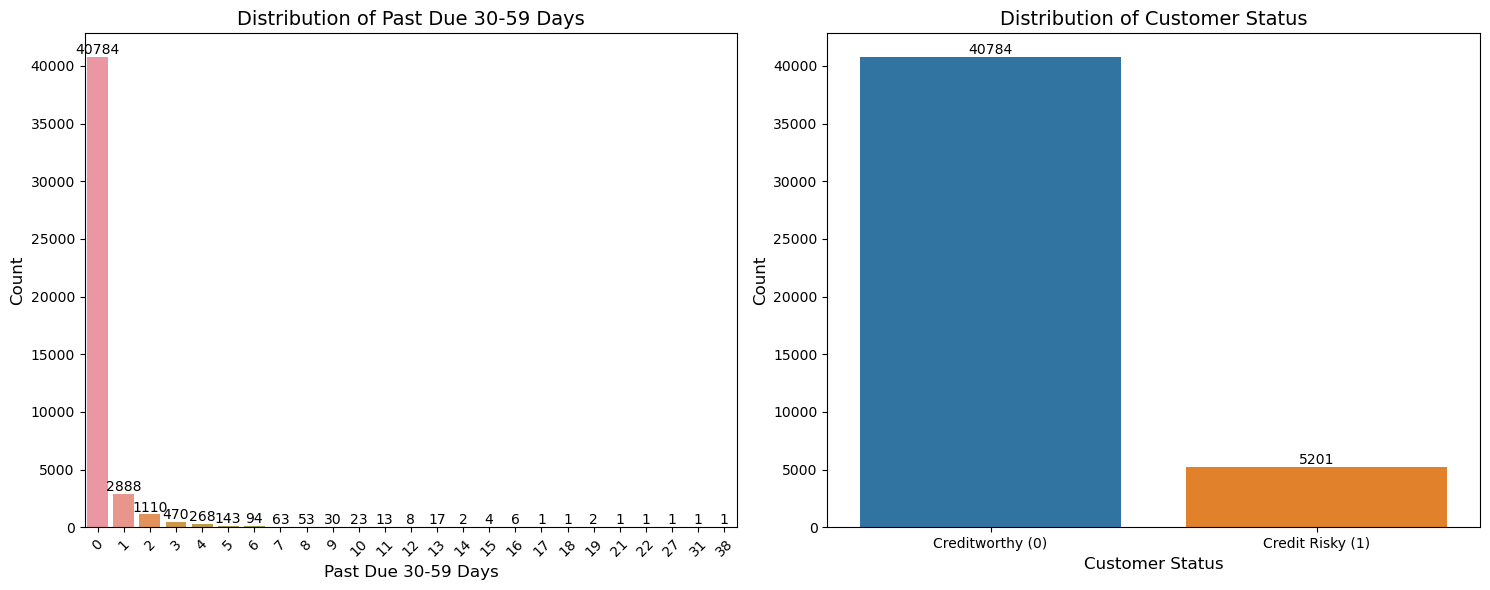

In [7]:
plt.figure(figsize=(15, 6))

# Function to add data labels
def add_data_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Subplot for 'pastdue_30_59'
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='pastdue_30_59', data=credit_grouped)
plt.title('Distribution of Past Due 30-59 Days', fontsize=14)
plt.xlabel('Past Due 30-59 Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax1)

# Subplot for 'customer_status'
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='customer_status', data=credit_grouped)
plt.title('Distribution of Customer Status', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Creditworthy (0)', 'Credit Risky (1)'], fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax2)

plt.tight_layout()
plt.show()



In [8]:
credit_grouped['customer_status'] = credit_grouped['pastdue_60_89'].apply(lambda x: 1 if x > 0 else 0)

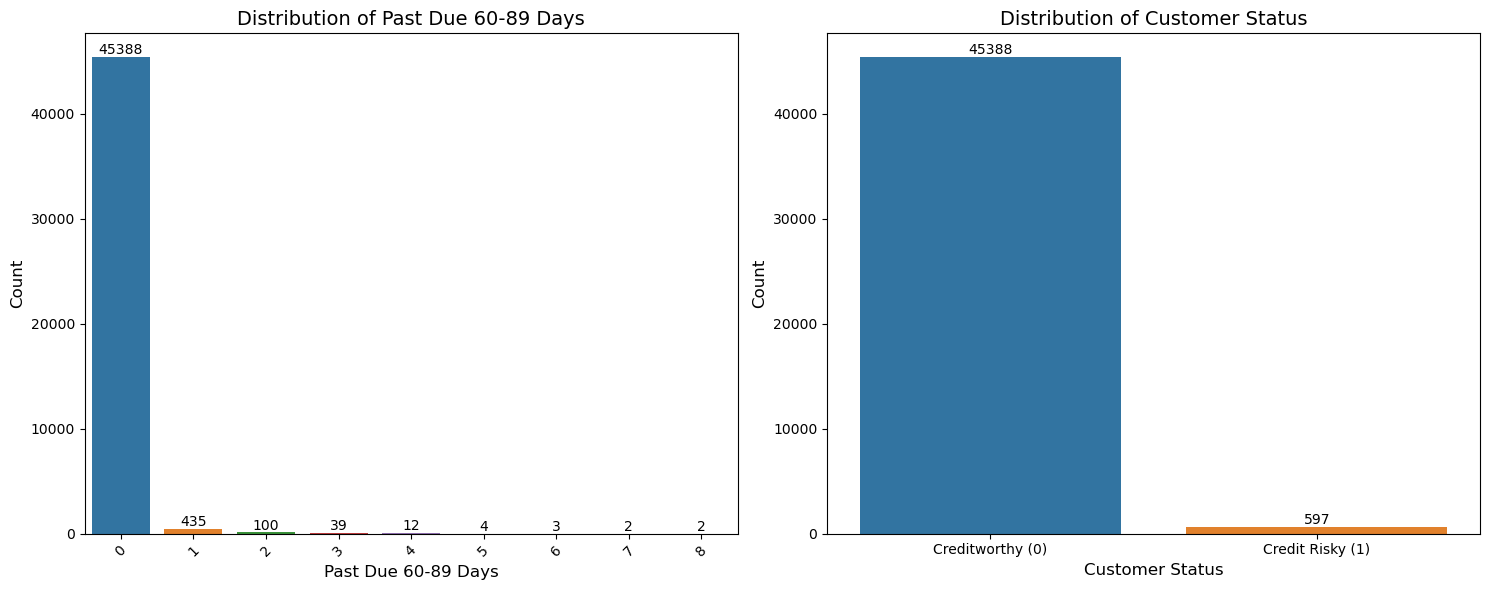

In [9]:
plt.figure(figsize=(15, 6))

# Subplot for 'pastdue_60_89'
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='pastdue_60_89', data=credit_grouped)
plt.title('Distribution of Past Due 60-89 Days', fontsize=14)
plt.xlabel('Past Due 60-89 Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax1)

# Subplot for 'customer_status'
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='customer_status', data=credit_grouped)
plt.title('Distribution of Customer Status', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Creditworthy (0)', 'Credit Risky (1)'], fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax2)

plt.tight_layout()
plt.show()



In [10]:

#Right now our 0-1 tagging is using 60 day past due customers. If we wanna change it back to 30 days past due, we simply run this code again.
#credit_grouped['customer_status'] = credit_grouped['pastdue_30_59'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
merged_df = pd.merge(credit_grouped[["customer_status"]], application_df, how='inner', left_index=True, right_index=True)

In [12]:
merged_df.head()

,customer_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,,
5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [13]:
merged_df.to_csv('merged_df')

In [14]:
#Converting "DAYS_BIRTH" column to Age
merged_df['AGE'] = round(-merged_df["DAYS_BIRTH"]/365.25)
merged_df.drop(columns=['DAYS_BIRTH'], inplace=True)
merged_df['AGE'].unique()

array([33., 59., 52., 62., 46., 49., 29., 51., 27., 30., 35., 32., 56.,
       43., 44., 34., 55., 47., 42., 37., 28., 61., 57., 45., 54., 40.,
       39., 48., 24., 21., 36., 26., 50., 63., 58., 41., 60., 31., 38.,
       53., 22., 64., 23., 25., 65., 67., 66., 69., 68.])

In [15]:
#Converting "DAYS_EMPLOYED" column to Years of Employment
merged_df['YEARS_EMPLOYED'] = round(-merged_df["DAYS_EMPLOYED"]/365.25)
merged_df.drop(columns=['DAYS_EMPLOYED'], inplace=True)
merged_df['YEARS_EMPLOYED'].unique()

array([   12.,     3.,     8., -1000.,     2.,     4.,     6.,     9.,
          19.,    15.,     5.,    13.,     7.,    17.,    30.,    16.,
          11.,     1.,    10.,    24.,    14.,    25.,     0.,    20.,
          27.,    18.,    21.,    23.,    22.,    28.,    39.,    32.,
          33.,    37.,    26.,    38.,    31.,    29.,    35.,    34.,
          41.,    40.,    36.,    42.,    43.])

In [16]:
#For years employed, negative values mean applicant doesn't work, so we convert negative values to 0 as well
merged_df.loc[(merged_df['YEARS_EMPLOYED'] < 0), 'YEARS_EMPLOYED'] = 0

In [17]:
merged_df.head()

,customer_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
ID,,,,,,,,,,,,,,,,,,
5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,33.0,12.0
5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,33.0,12.0
5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,59.0,3.0
5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52.0,8.0
5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52.0,8.0


In [18]:
for column in merged_df.columns:
    value_counts_result = merged_df[column].value_counts()
    print(f"\nValue counts for column '{column}':\n{value_counts_result}")



Value counts for column 'customer_status':
customer_status
0    35902
1      555
Name: count, dtype: int64

Value counts for column 'CODE_GENDER':
CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64

Value counts for column 'FLAG_OWN_CAR':
FLAG_OWN_CAR
N    22614
Y    13843
Name: count, dtype: int64

Value counts for column 'FLAG_OWN_REALTY':
FLAG_OWN_REALTY
Y    24506
N    11951
Name: count, dtype: int64

Value counts for column 'CNT_CHILDREN':
CNT_CHILDREN
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: count, dtype: int64

Value counts for column 'AMT_INCOME_TOTAL':
AMT_INCOME_TOTAL
135000.0    4309
180000.0    3097
157500.0    3089
112500.0    2956
225000.0    2926
            ... 
147150.0       1
177750.0       1
134995.5       1
31950.0        1
74061.0        1
Name: count, Length: 265, dtype: int64

Value counts for column 'NAME_INCOME_TYPE':
NAME_INCOME_TYPE
Working                 18819
Commercial ass

In [19]:
#Dropping what is not necessary. "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL" is what info customers left when applying. It's not gonna be necessary or decisive on our model.
merged_df.drop(columns=["FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"], inplace=True)


In [20]:
merged_df.isnull().sum()

customer_status            0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
AGE                        0
YEARS_EMPLOYED             0
dtype: int64

In [21]:
merged_df.dtypes

customer_status          int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE                    float64
YEARS_EMPLOYED         float64
dtype: object

In [22]:
# We're going to address the issue of "OCCUPATION_TYPE" having so many NaN values by training a machine learning model and filling the missing values with that.
# Separate the rows with and without NaN values in the 'OCCUPATION_TYPE' column
df_nan = merged_df[merged_df['OCCUPATION_TYPE'].isna()]
df_not_nan = merged_df.dropna(subset=['OCCUPATION_TYPE'])

# Encode categorical columns
label_encoder = LabelEncoder()
encoded_labels = {}
for column in df_not_nan.select_dtypes(include=['object']).columns:
    df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
    encoded_labels[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Identify features (X) and target variable (y)
X_ot = df_not_nan.drop(['OCCUPATION_TYPE'], axis=1)
y_ot = label_encoder.fit_transform(df_not_nan['OCCUPATION_TYPE'])  # Encode target variable

# Split the data into training and testing sets
X_train_ot, X_test_ot, y_train_ot, y_test_ot = train_test_split(X_ot, y_ot, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train_ot, y_train_ot)

# Evaluate the model on the test set
y_true = y_test_ot  # True labels from the test set
y_pred = rf_classifier.predict(X_test_ot)  # Predicted labels on the test set


# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_38657/1937152166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_38657/1937152166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_38657/1937152166.py:10: SettingWithCopyWarning: 
A value 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       270
           1       0.96      0.92      0.94       118
           2       0.94      0.85      0.89       136
           3       0.92      0.91      0.92       736
           4       0.88      0.92      0.90       431
           5       0.86      0.92      0.89        13
           6       0.96      0.88      0.92       293
           7       1.00      0.90      0.95        10
           8       0.92      0.94      0.93      1219
           9       1.00      0.94      0.97        33
          10       0.92      0.91      0.91       591
          11       0.94      0.95      0.94       243
          12       0.98      0.86      0.92        76
          13       0.93      1.00      0.96        13
          14       0.88      0.92      0.90       671
          15       1.00      0.79      0.88        24
          16       0.92      0.86      0.89       116
    

In [23]:
# Identify rows with NaN values in the target variable
X_nan = df_nan.drop(['OCCUPATION_TYPE'], axis=1)

# Encode categorical columns in the NaN rows
for column in X_nan.select_dtypes(include=['object']).columns:
    # Check if label encoder has seen the label before transforming
    X_nan[column] = X_nan[column].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)

# Predict the missing values
predicted_occupations = rf_classifier.predict(X_nan)

# Reverse label encoding using the mapping dictionary
predicted_occupations_original = [encoded_labels['OCCUPATION_TYPE'].get(label, label) for label in predicted_occupations]

predicted_occupations_original = [key for label in predicted_occupations for key, value in encoded_labels['OCCUPATION_TYPE'].items() if value == label]

# Fill NaN values with predicted values
merged_df.loc[merged_df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = predicted_occupations_original

/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_38657/1842177641.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_nan[column] = X_nan[column].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)


In [24]:
merged_df.describe()

,customer_status,CNT_CHILDREN,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
count,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000
mean,0.015223,0.430315,1.866857e+05,2.198453,43.746057,6.036783
std,0.122442,0.742367,1.017892e+05,0.911686,11.513873,6.488058
min,0.000000,0.000000,2.700000e+04,1.000000,21.000000,0.000000
25%,0.000000,0.000000,1.215000e+05,2.000000,34.000000,1.000000
50%,0.000000,0.000000,1.575000e+05,2.000000,43.000000,4.000000
75%,0.000000,1.000000,2.250000e+05,3.000000,53.000000,9.000000
max,1.000000,19.000000,1.575000e+06,20.000000,69.000000,43.000000


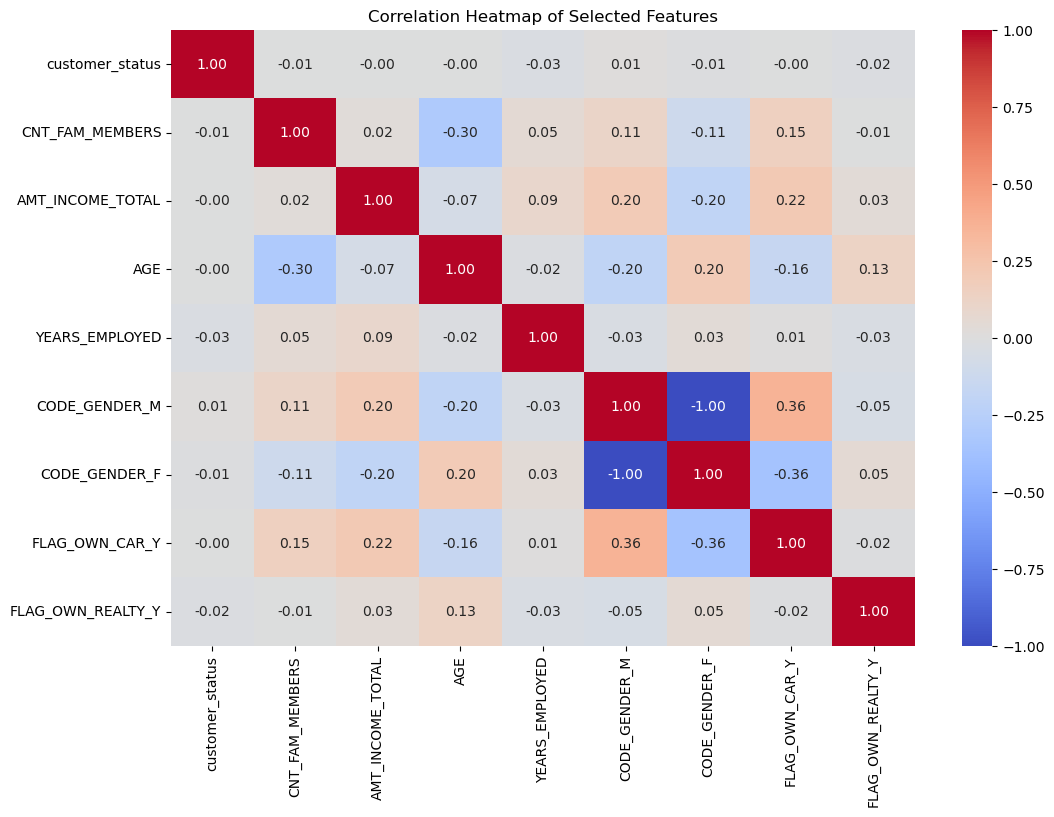

In [25]:
# One-hot encoding for the selected categorical variables
merged_df_subset = pd.get_dummies(merged_df, columns=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'])

# Selecting a subset of key features for correlation analysis
selected_features = ['customer_status', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 
                     'AGE', 'YEARS_EMPLOYED', 
                     'CODE_GENDER_M', 'CODE_GENDER_F', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y']

# Keeping only the selected features
merged_df_subset = merged_df_subset[selected_features]

# Calculating the correlation matrix for the subset
corr_matrix_subset = merged_df_subset.corr()

# Plotting the heatmap for the subset
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_subset, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [26]:
merged_df.dtypes

customer_status          int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE                    float64
YEARS_EMPLOYED         float64
dtype: object

In [27]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

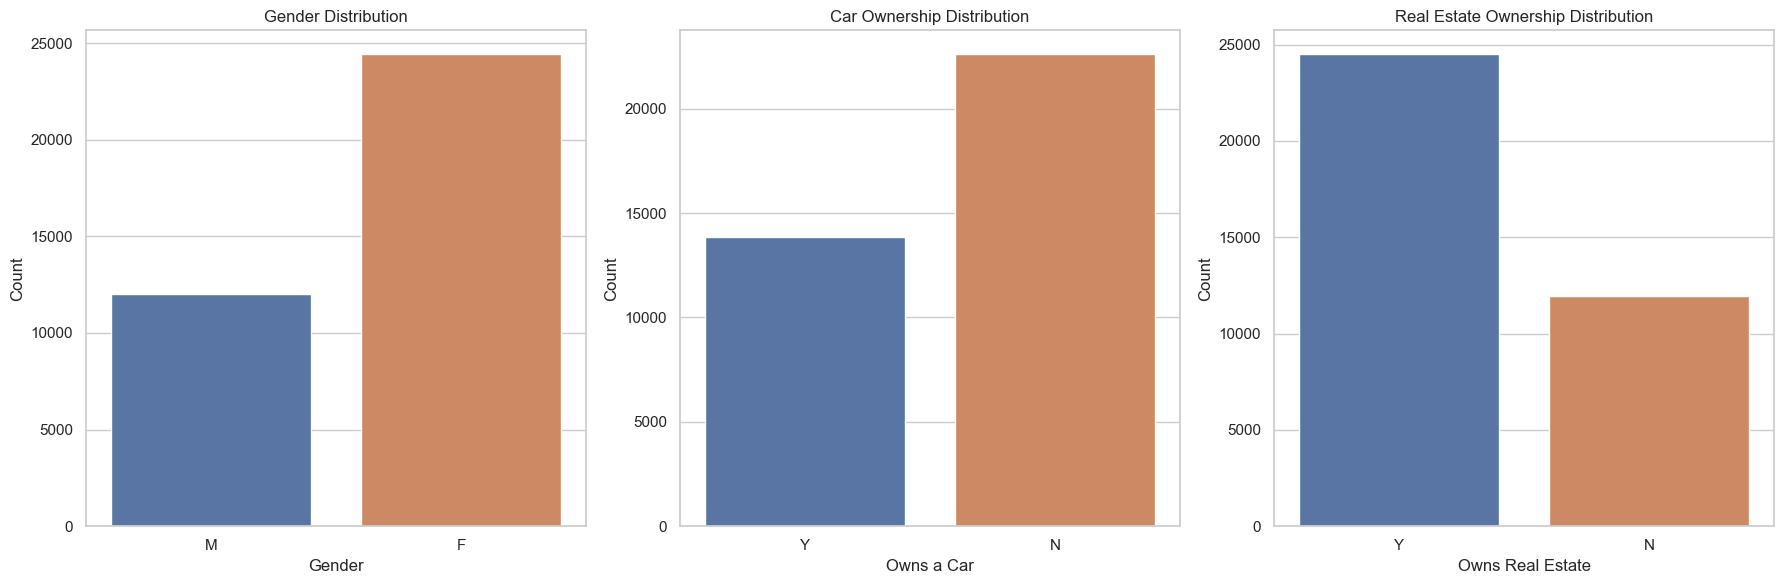

In [28]:
# Plotting distributions of some categorical variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gender distribution
sns.countplot(x='CODE_GENDER', data=merged_df, ax=axes[0])
axes[0].set_title('Gender Distribution')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# Car ownership distribution
sns.countplot(x='FLAG_OWN_CAR', data=merged_df, ax=axes[1])
axes[1].set_title('Car Ownership Distribution')
axes[1].set_xlabel('Owns a Car')
axes[1].set_ylabel('Count')

# Real estate ownership distribution
sns.countplot(x='FLAG_OWN_REALTY', data=merged_df, ax=axes[2])
axes[2].set_title('Real Estate Ownership Distribution')
axes[2].set_xlabel('Owns Real Estate')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

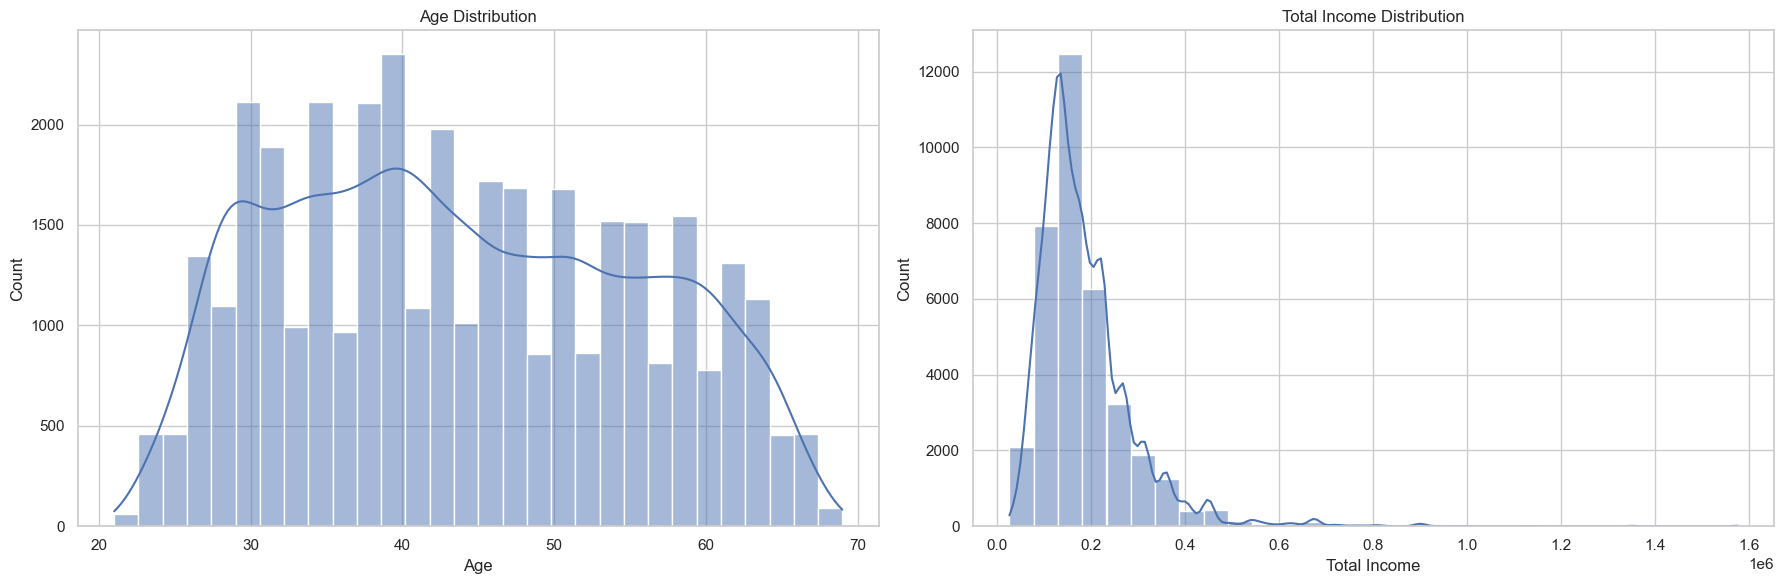

In [29]:
# Plotting distributions of some numerical variables
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Age distribution
sns.histplot(merged_df['AGE'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Total Income distribution
sns.histplot(merged_df['AMT_INCOME_TOTAL'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Total Income Distribution')
axes[1].set_xlabel('Total Income')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

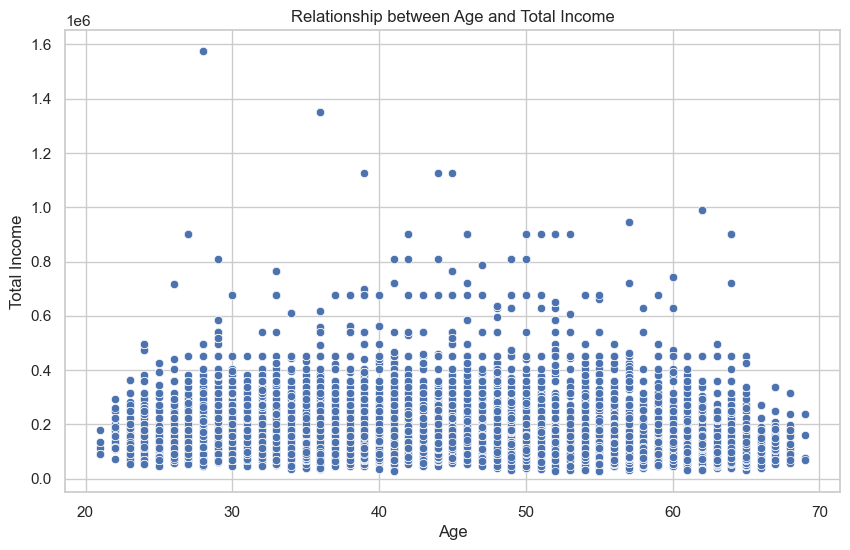

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE', y='AMT_INCOME_TOTAL', data=merged_df)
plt.title('Relationship between Age and Total Income')
plt.xlabel('Age')
plt.ylabel('Total Income')
plt.show()

In [31]:
# Children Count column is a subset of Family Members Count column, we will drop one and simplify the other one to reduce the noise.
merged_df.drop(columns=['CNT_CHILDREN'], inplace=True)
merged_df['CNT_FAM_MEMBERS'] = merged_df['CNT_FAM_MEMBERS'].apply(lambda x: x if x < 4 else '4 or more')

In [32]:
# We will bin the Income Amount to 4 quartiles.
income_quartiles = merged_df['AMT_INCOME_TOTAL'].quantile([0.25, 0.5, 0.75])
bins_income = [0, income_quartiles[0.25], income_quartiles[0.5], income_quartiles[0.75], np.inf]
labels_income = ['Up to 121,500', '121,500-157,500', '157,000-225,000', '225,000+']
merged_df['INCOME_BINNED'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=bins_income, labels=labels_income, right=False)


In [33]:
# Binning the years employed
bins_years_employed = [0, 5, 10, 15, 20, np.inf]
labels_years_employed = ['0-5 years', '6-10 years', '11-15 years', '16-20 years', '21+ years']
merged_df['YEARS_EMPLOYED_BINNED'] = pd.cut(merged_df['YEARS_EMPLOYED'], bins=bins_years_employed, labels=labels_years_employed, right=False)

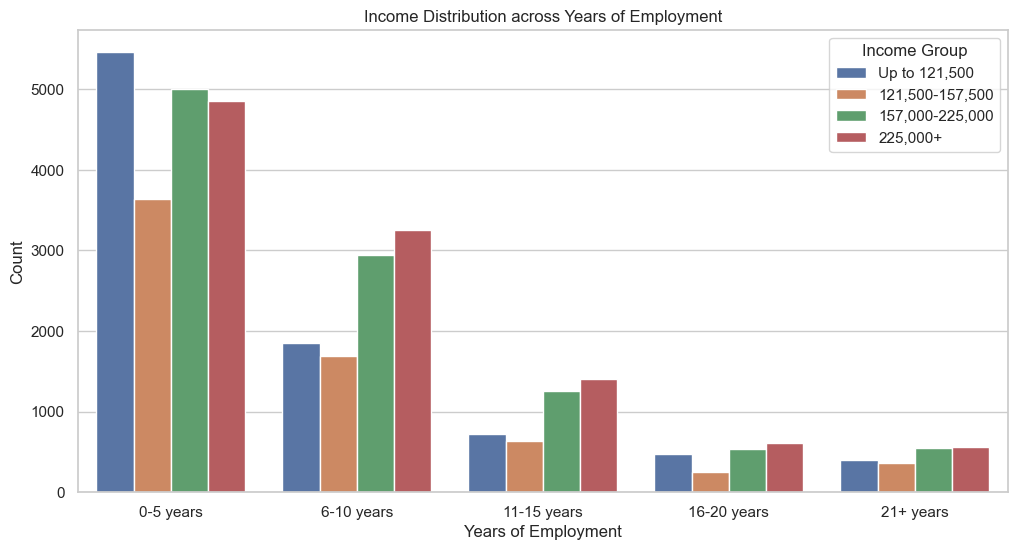

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(x='YEARS_EMPLOYED_BINNED', hue='INCOME_BINNED', data=merged_df)
plt.title('Income Distribution across Years of Employment')
plt.xlabel('Years of Employment')
plt.ylabel('Count')
plt.legend(title='Income Group')
plt.show()

In [35]:
# Binning the age
bins_age = [21, 36, 51, 66, np.inf]
labels_age = ['21-35 years', '36-50 years', '51-65 years', '66+ years']
merged_df['AGE_BINNED'] = pd.cut(merged_df['AGE'], bins=bins_age, labels=labels_age, right=False)

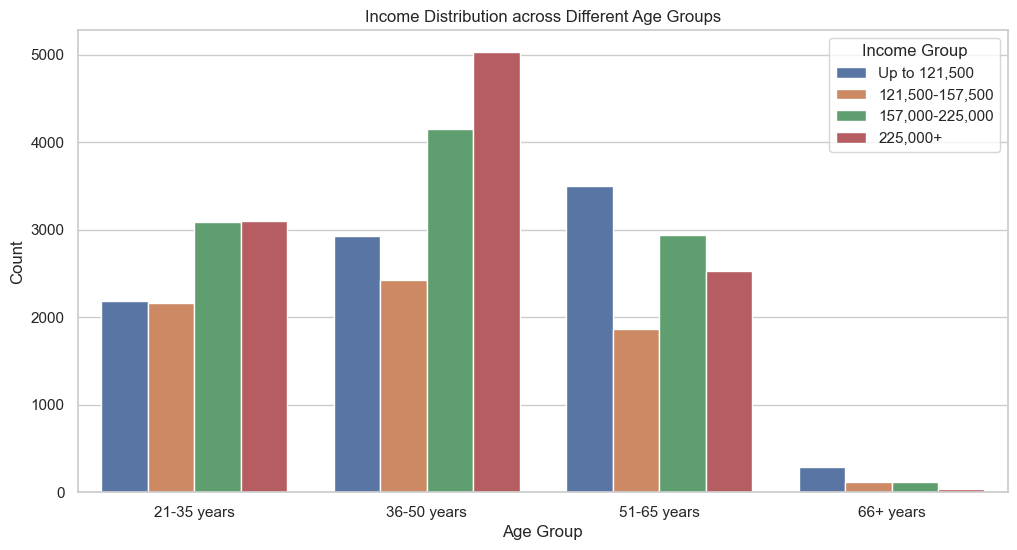

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(x='AGE_BINNED', hue='INCOME_BINNED', data=merged_df)
plt.title('Income Distribution across Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Income Group')
plt.show()

In [37]:
merged_df.head()

,customer_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,INCOME_BINNED,YEARS_EMPLOYED_BINNED,AGE_BINNED
ID,,,,,,,,,,,,,,,,
5008804,0,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,Managers,2.0,33.0,12.0,"225,000+",11-15 years,21-35 years
5008805,0,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,Managers,2.0,33.0,12.0,"225,000+",11-15 years,21-35 years
5008806,0,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,Security staff,2.0,59.0,3.0,"Up to 121,500",0-5 years,51-65 years
5008808,0,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,52.0,8.0,"225,000+",6-10 years,51-65 years
5008809,0,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,52.0,8.0,"225,000+",6-10 years,51-65 years


In [38]:
merged_df.drop(columns=['AGE', 'YEARS_EMPLOYED', 'AMT_INCOME_TOTAL'], inplace=True)

In [39]:
# Converting binned columns to string type
merged_df['AGE_BINNED'] = merged_df['AGE_BINNED'].astype(str)
merged_df['INCOME_BINNED'] = merged_df['INCOME_BINNED'].astype(str)
merged_df['YEARS_EMPLOYED_BINNED'] = merged_df['YEARS_EMPLOYED_BINNED'].astype(str)


In [40]:
# Selecting categorical columns for encoding and numerical columns for scaling
categorical_cols = merged_df.select_dtypes(include=['object', 'category']).columns
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).drop('customer_status', axis=1).columns

# Before applying the ColumnTransformer we make sure all categorical data are strings
for col in categorical_cols:
    merged_df[col] = merged_df[col].astype(str)

# Apply the ColumnTransformer
ct = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(sparse=False), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
], remainder='passthrough')

# Applying ColumnTransformer to feature set
X = ct.fit_transform(merged_df.drop('customer_status', axis=1))

# Target variable
y = merged_df['customer_status']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
# Applying SMOTE to training set
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [42]:
# Apply undersampling to the training data
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [43]:
# ### Tuning Logistic Regression for SMOTE
# # Define the model
# lr_smote = LogisticRegression(random_state=42)

# # Define the parameter grid
# param_grid_lr_smote = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
# }

# # Create GridSearchCV
# grid_search_lr_smote = GridSearchCV(estimator=lr_smote, param_grid=param_grid_lr_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_lr_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data (Logistic Regression):", grid_search_lr_smote.best_params_)

In [44]:
# Create the model
lr_smote = LogisticRegression(random_state=42, C= 0.1, penalty= 'l1', solver='saga')

# Train the model on SMOTE data
lr_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
lr_predictions_smote = lr_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, lr_predictions_smote))
print(confusion_matrix(y_test, lr_predictions_smote))

              precision    recall  f1-score   support

           0       0.99      0.60      0.74      8981
           1       0.02      0.57      0.04       134

    accuracy                           0.60      9115
   macro avg       0.50      0.58      0.39      9115
weighted avg       0.98      0.60      0.73      9115

[[5361 3620]
 [  58   76]]


In [45]:
# ### Tuning Logistic Regression for Undersampled
# # Define the model
# lr_under = LogisticRegression(random_state=42)

# # Define the parameter grid
# param_grid_lr_under = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
# }

# # Create GridSearchCV
# grid_search_lr_under = GridSearchCV(estimator=lr_under, param_grid=param_grid_lr_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_lr_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data (Logistic Regression):", grid_search_lr_under.best_params_)

In [46]:
# Create the model
lr_under = LogisticRegression(random_state=42, C= 0.01, penalty= 'l2', solver='newton-cg')

# Train the model on Under Sampled data
lr_under.fit(X_train_under, y_train_under)

# Predict on the test set
lr_predictions_under = lr_under.predict(X_test)

# Evaluate the model
print(classification_report(y_test, lr_predictions_under))
print(confusion_matrix(y_test, lr_predictions_under))

              precision    recall  f1-score   support

           0       0.99      0.56      0.71      8981
           1       0.02      0.56      0.04       134

    accuracy                           0.56      9115
   macro avg       0.50      0.56      0.37      9115
weighted avg       0.97      0.56      0.70      9115

[[4994 3987]
 [  59   75]]


In [47]:
# ### Tuning RandomForest for SMOTE

# # Define the model
# rf_smote = RandomForestClassifier(random_state=42)

# # Define the parameter grid
# param_grid_rf_smote = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Create GridSearchCV
# grid_search_rf_smote = GridSearchCV(estimator=rf_smote, param_grid=param_grid_rf_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_rf_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data (RandomForest):", grid_search_rf_smote.best_params_)

In [48]:
# Create the model
rf_smote = RandomForestClassifier(random_state=42, n_estimators=200, min_samples_split=4, criterion= 'gini')

rf_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
rf_predictions_smote = rf_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, rf_predictions_smote))
print(confusion_matrix(y_test, rf_predictions_smote))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      8981
           1       0.16      0.29      0.21       134

    accuracy                           0.97      9115
   macro avg       0.57      0.63      0.59      9115
weighted avg       0.98      0.97      0.97      9115

[[8776  205]
 [  95   39]]


In [49]:
# ### Tuning RandomForest for Undersampled

# # Define the model
# rf_under = RandomForestClassifier(random_state=42)

# # Define the parameter grid
# param_grid_rf_under = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Create GridSearchCV
# grid_search_rf_under = GridSearchCV(estimator=rf_under, param_grid=param_grid_rf_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_rf_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data (RandomForest):", grid_search_rf_under.best_params_)

In [50]:
# Create the model
rf_under = RandomForestClassifier(random_state=42, max_depth= 30, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)

rf_under.fit(X_train_under, y_train_under)

# Predict on the test set
rf_under_predictions = rf_under.predict(X_test)

# Evaluate the model
print(classification_report(y_test, rf_under_predictions))
print(confusion_matrix(y_test, rf_under_predictions))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78      8981
           1       0.03      0.67      0.05       134

    accuracy                           0.64      9115
   macro avg       0.51      0.66      0.42      9115
weighted avg       0.98      0.64      0.77      9115

[[5756 3225]
 [  44   90]]


/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [51]:
# ### Tuning XGBoost for SMOTE

# # Define the model
# xgb_smote = XGBClassifier(random_state=42)

# # Define the parameter grid
# param_grid_smote = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [0, 3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # Create GridSearchCV
# grid_search_smote = GridSearchCV(estimator=xgb_smote, param_grid=param_grid_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data:", grid_search_smote.best_params_)

In [52]:
# Create and train the model
xgb_smote = XGBClassifier(use_label_encoder=False, random_state=42, colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 0, n_estimators= 200, subsample= 0.8)
xgb_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
xgb_predictions_smote = xgb_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, xgb_predictions_smote))
print(confusion_matrix(y_test, xgb_predictions_smote))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      8981
           1       0.18      0.35      0.24       134

    accuracy                           0.97      9115
   macro avg       0.59      0.66      0.61      9115
weighted avg       0.98      0.97      0.97      9115

[[8771  210]
 [  87   47]]


In [53]:
# ### Tuning XGBoost for Undersampled

# # Define the model
# xgb_under = XGBClassifier(random_state=42)

# # Define the parameter grid
# param_grid_under = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [0, 3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # Create GridSearchCV
# grid_search_under = GridSearchCV(estimator=xgb_under, param_grid=param_grid_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data:", grid_search_under.best_params_)

In [54]:
# Create and train the model
xgb_under = XGBClassifier(use_label_encoder=False, random_state=42, colsample_bytree= 0.9, learning_rate= 0.2, max_depth= 0, n_estimators= 200, subsample= 0.8)
xgb_under.fit(X_train_under, y_train_under)

# Predict on the test set
xgb_predictions_under = xgb_under.predict(X_test)

# Evaluate the model
print(classification_report(y_test, xgb_predictions_under))
print(confusion_matrix(y_test, xgb_predictions_under))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76      8981
           1       0.03      0.69      0.05       134

    accuracy                           0.62      9115
   macro avg       0.51      0.66      0.41      9115
weighted avg       0.98      0.62      0.75      9115

[[5571 3410]
 [  41   93]]


In [55]:
# ### Tuning MLP for SMOTE

# # Define the model
# mlp_smote = MLPClassifier(random_state=42)

# # Define the parameter grid
# param_grid_mlp_smote = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate_init': [0.001, 0.01],
#     'max_iter': [200, 300]
# }

# # Create GridSearchCV
# grid_search_mlp_smote = GridSearchCV(estimator=mlp_smote, param_grid=param_grid_mlp_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_mlp_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data (MLPClassifier):", grid_search_mlp_smote.best_params_)

In [56]:
# Create and train the model
nn_smote = MLPClassifier(random_state=42, alpha=0.0001, activation='tanh', solver='adam', hidden_layer_sizes= (100,), learning_rate_init= 0.001, max_iter= 300)
nn_smote.fit(X_train_smote, y_train_smote)


# Predict on the test set
nn_predictions_smote = nn_smote.predict(X_test)

# Evaluate the model
print(classification_report(y_test, nn_predictions_smote))
print(confusion_matrix(y_test, nn_predictions_smote))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      8981
           1       0.10      0.45      0.17       134

    accuracy                           0.93      9115
   macro avg       0.55      0.69      0.57      9115
weighted avg       0.98      0.93      0.95      9115

[[8460  521]
 [  74   60]]


In [57]:
# ### Tuning MLP for Undersampled

# # Define the model
# mlp_under = MLPClassifier(random_state=42)

# # Define the parameter grid
# param_grid_mlp_under = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate_init': [0.001, 0.01],
#     'max_iter': [200, 300]
# }

# # Create GridSearchCV
# grid_search_mlp_under = GridSearchCV(estimator=mlp_under, param_grid=param_grid_mlp_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_mlp_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data (MLPClassifier):", grid_search_mlp_under.best_params_)

In [58]:
# Create and train the model
nn_under = MLPClassifier(random_state=42, alpha=0.05, activation='tanh', solver='adam', hidden_layer_sizes= (100,), learning_rate_init= 0.01, max_iter= 300)
nn_under.fit(X_train_under, y_train_under)

# Predict on the test set
nn_predictions_under = nn_under.predict(X_test)

# Evaluate the model
print(classification_report(y_test, nn_predictions_under))
print(confusion_matrix(y_test, nn_predictions_under))

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      8981
           1       0.03      0.73      0.05       134

    accuracy                           0.60      9115
   macro avg       0.51      0.66      0.40      9115
weighted avg       0.98      0.60      0.73      9115

[[5332 3649]
 [  36   98]]
